In [ ]:
import scanpy as sc
from tidyverse.dummy import *
from sctools import pipeline
from sctools.scplotting import recolor, kneeplot_split
from sctools.de import gene_expression_to_flat_df_NEW, scanpy_DE_to_dataframe_fast, get_de_genes
# import scHCLpy.adata
from crukiopy_release.datatools import read_metadata
from crukiopy_release.colormaps import celltype_order_coarse_celltype, color_dict_diagnosis, cmap_subtypes
import gc
from sccoda.util import cell_composition_data as dat
from sccoda.util import data_visualization as viz
from sccoda.util import comp_ana as mod
from cellprop_utils import plot_patient_diagnosis

from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('svg')
set_matplotlib_formats('png')
from sctools.composition import clustered_heatmap_from_sccoda_CLR, compositional_pca, plot_pca_loadings

# Create data

the original full dataset is located here:
```gsutil -m cp gs://cruk-adata-for-cellbrowser/Aug2022_adata/Atlas/Eso_Atlas.h5ad .```

In [2]:
adata = sc.read_h5ad('/home/mstrasse/TB4/Aug2022_adata/Atlas/Eso_Atlas.h5ad')

In [3]:
adata = adata[adata.obs.doublet_score<0.2]
adata = adata[adata.obs.percent_mito<0.1]

/home/mstrasse/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


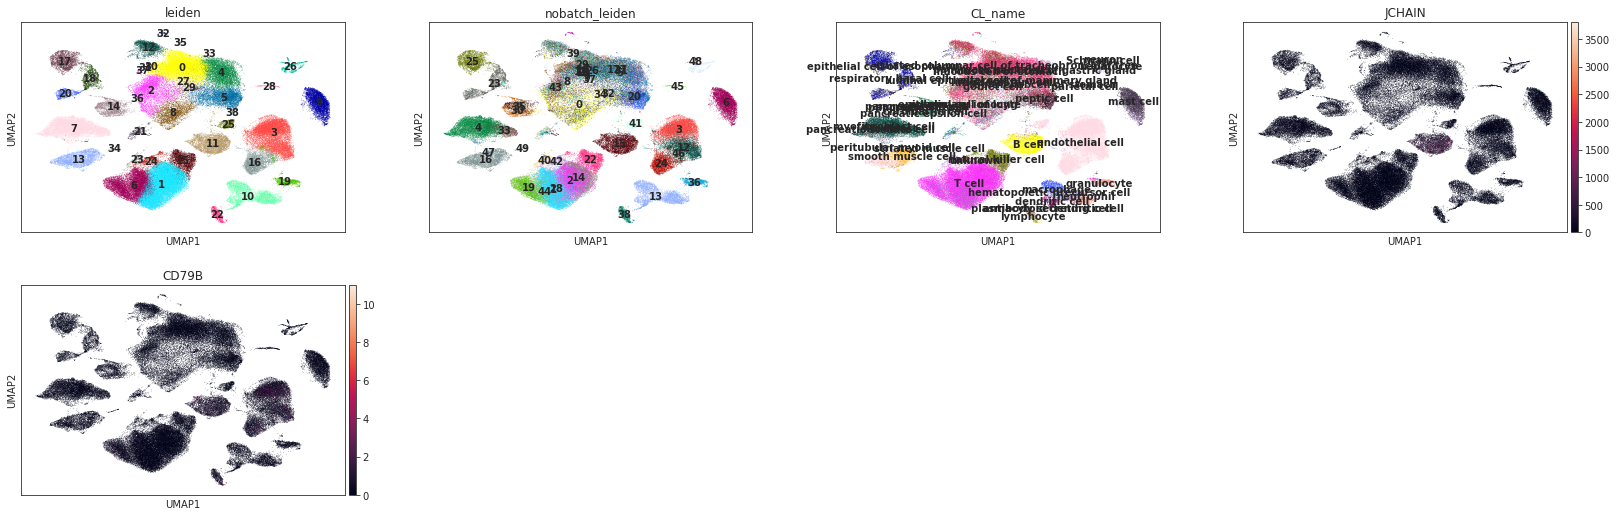

In [5]:
sc.pl.umap(adata, color=['leiden', 'nobatch_leiden', 'CL_name', 'JCHAIN', 'CD79B'], legend_loc='on data')

/home/mstrasse/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


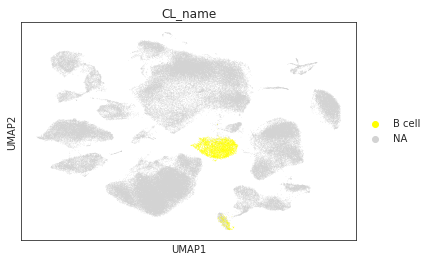

In [14]:
sc.pl.umap(adata, color=['CL_name'], groups='B cell')

In [15]:
adata = adata[adata.obs.leiden.isin(["11", '22'])]

/home/mstrasse/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


In [16]:
A = sc.AnnData(adata.X, var=adata.var, obs=adata.obs)
A.raw = A
# del adata
# gc.collect()

07/06/2022 07:05:38 PM annotating QC
07/06/2022 07:05:39 PM annotating and filtering for coding genes
/home/mstrasse/miniconda3/lib/python3.7/site-packages/sctools/annotations.py:54: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
07/06/2022 07:05:41 PM filtering cells for UMI content
07/06/2022 07:05:41 PM Cells: 5334 -> 5334
07/06/2022 07:05:41 PM filtering cells for mito content
07/06/2022 07:05:42 PM Cells: 5334 -> 5334
07/06/2022 07:05:42 PM Annotating Cell cycle
07/06/2022 07:05:42 PM calculating cell cycle phase
07/06/2022 07:05:42 PM computing score 'S_score'
07/06/2022 07:05:42 PM computing score 'G2M_score'
07/06/2022 07:05:42 PM     'phase', cell cycle phase (adata.obs)
07/06/2022 07:05:42 PM Done: Annotating Cell cycle
07/06/2022 07:05:42 PM Zheng recipe
/home/mstrasse/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  U

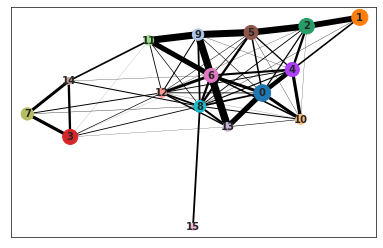

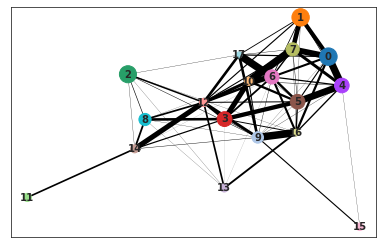

In [17]:
A = pipeline.michi_kallisto_recipe(A,  harmony_correction='samplename')
pipeline.differential_expression_michi_kallisto_recipe(A, 'leiden')

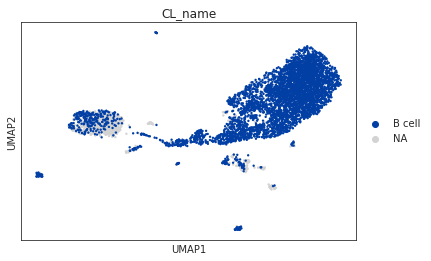

In [18]:
sc.pl.umap(A, color=['CL_name'], groups='B cell')

In [19]:
A.write_h5ad('/home/mstrasse/TB4/cellTypeProportions/Bcell_processed.h5ad')

/home/mstrasse/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


# Analysis

In [3]:
A = sc.read_h5ad('/home/mstrasse/TB4/cellTypeProportions/Bcell_processed.h5ad')
# fixing some diagnosis
from crukiopy_release.datatools import fix_diagnosis, diagnosis_fix_dict
A = fix_diagnosis(A)
df_meta = read_metadata()

# again fix diagnosis in those samples
df_meta = df_meta[df_meta.samplename.isin(A.obs.samplename.unique())].set_index('samplename').sort_values('diagnosis')
for s, d in diagnosis_fix_dict.items():
    df_meta.loc[s, 'diagnosis'] = d

/home/mstrasse/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
... storing 'diagnosis' as categorical
... storing 'sample_diagnosis' as categorical


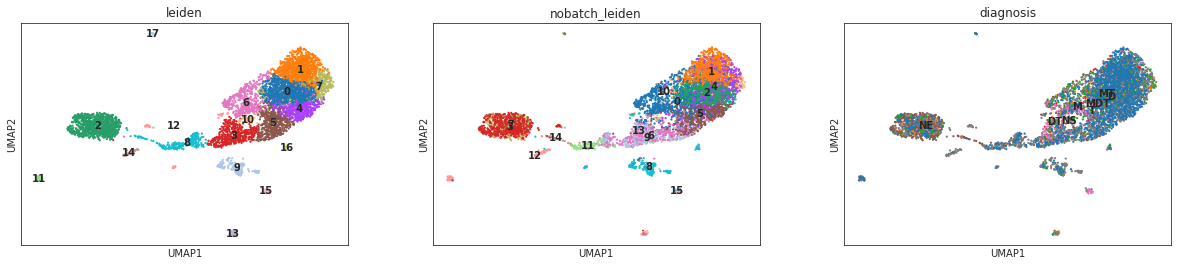

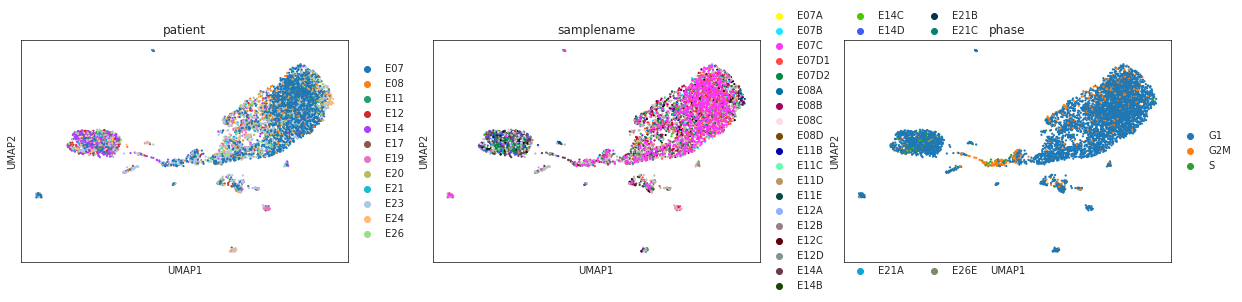

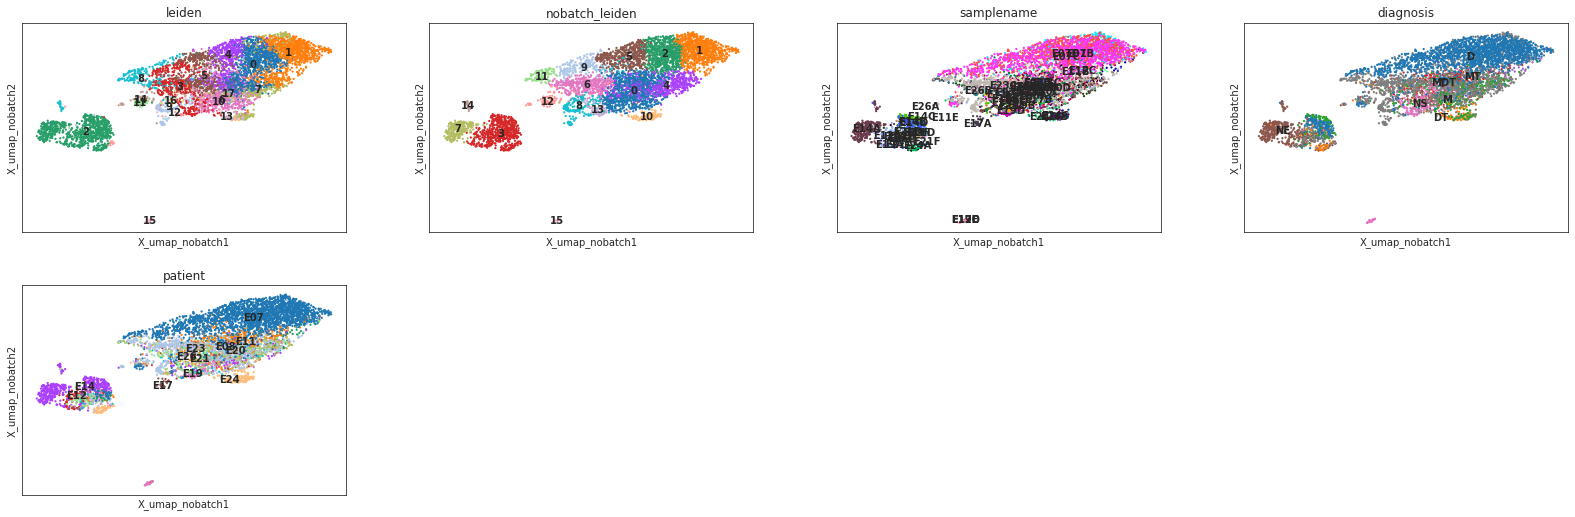

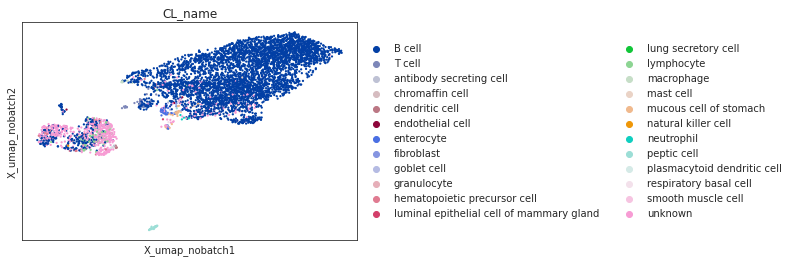

In [5]:
sc.pl.umap(A, color=['leiden', 'nobatch_leiden', 'diagnosis'], legend_loc='on data', size=20)
sc.pl.umap(A, color=['patient', 'samplename', 'phase'], size=20)

sc.pl.embedding(A, basis="X_umap_nobatch", color=['leiden', 'nobatch_leiden', 'samplename', 'diagnosis', 'patient',], legend_loc='on data', size=20)
sc.pl.embedding(A, basis="X_umap_nobatch", color=['CL_name'], size=20)

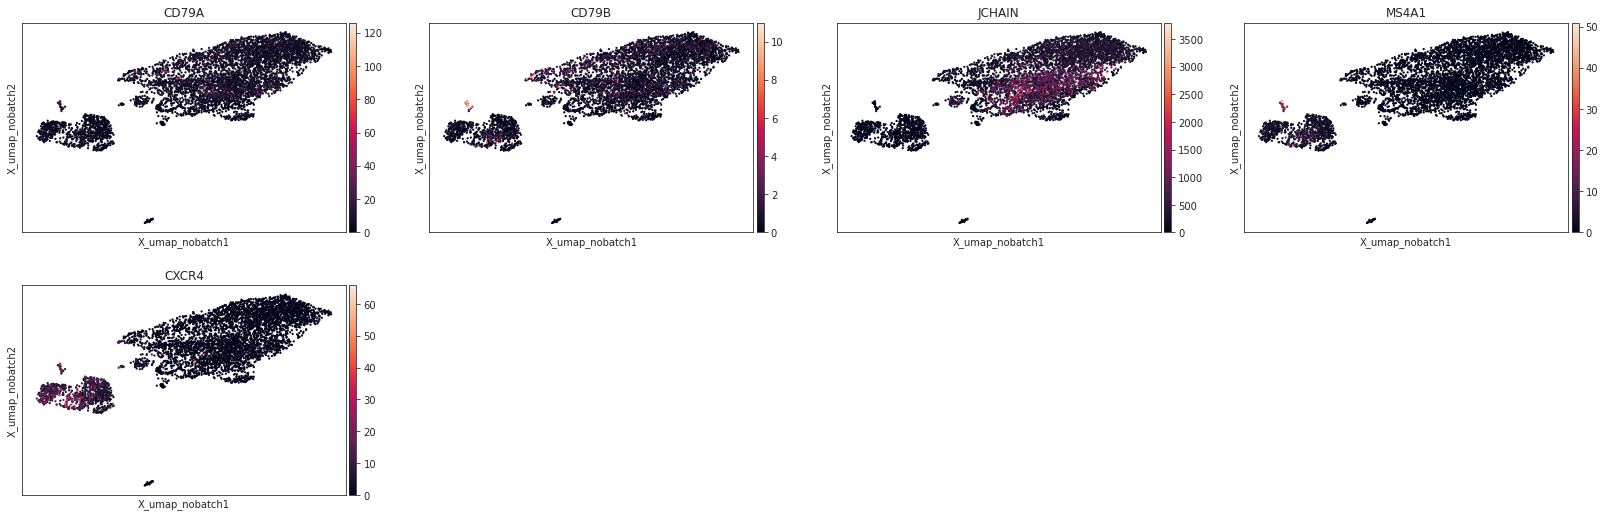

In [9]:
sc.pl.embedding(A, basis="X_umap_nobatch", color=['CD79A', 'CD79B', 'JCHAIN', "MS4A1","CXCR4"], size=20)

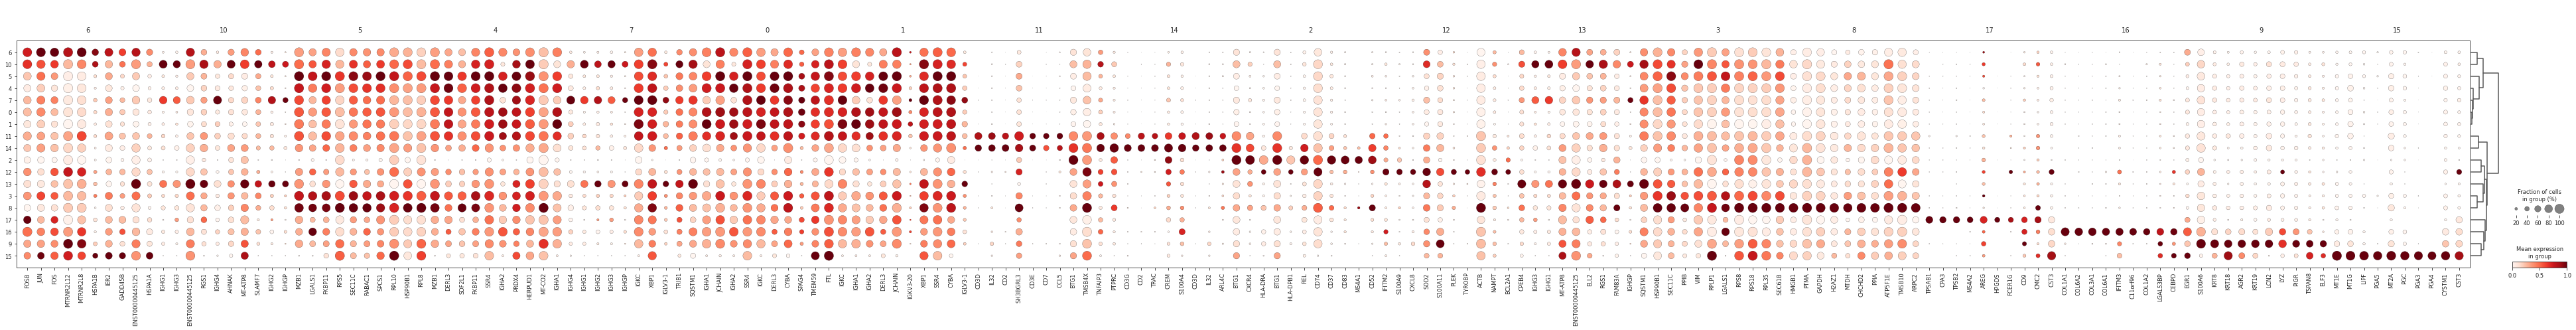

In [10]:
sc.pl.rank_genes_groups_dotplot(A, standard_scale='var', n_genes=10)

/home/mstrasse/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
categories: 0, 1, 2, etc.
var_group_labels: 13


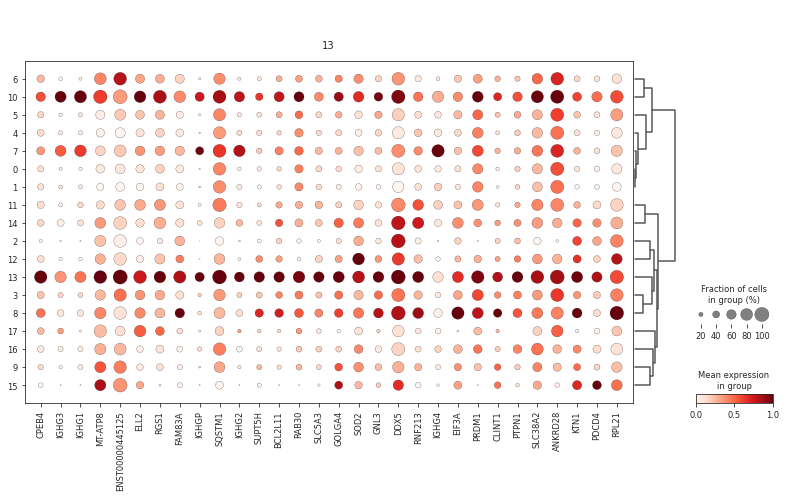

In [11]:
sc.pl.rank_genes_groups_dotplot(A, standard_scale='var', n_genes=30, groups=['13'])

In [6]:
doublets = [
    '15',
    '9',
    '16',
    '17',
    '14',
    '11',
    '12' # macro
]

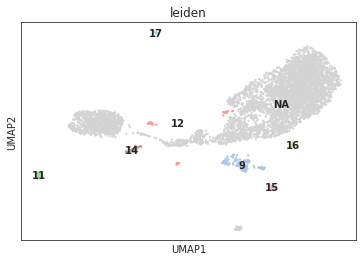

In [7]:
sc.pl.umap(A, color=['leiden', ], groups=doublets, legend_loc='on data', size=20)

In [8]:
A = A[~A.obs.leiden.isin(doublets)]
A = A[A.obs.diagnosis.isin(['NE', 'NS', 'M','D','T'])]
# remove dividing
A = A[~A.obs.leiden.isin(['8'])]

/home/mstrasse/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


/home/mstrasse/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


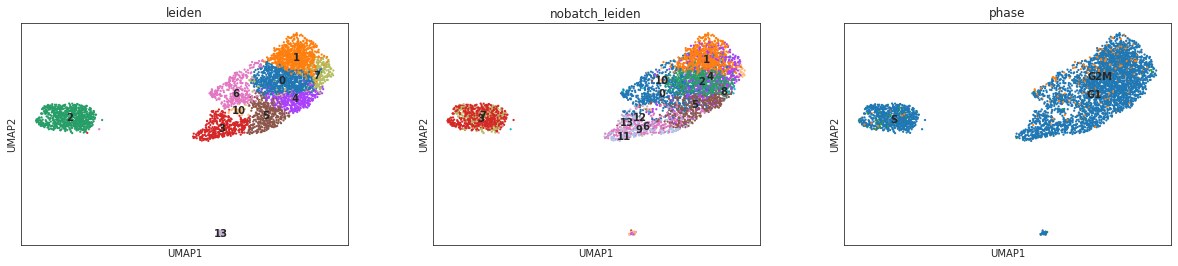

In [9]:
sc.pl.umap(A, color=['leiden', 'nobatch_leiden', 'phase'], legend_loc='on data', size=20)

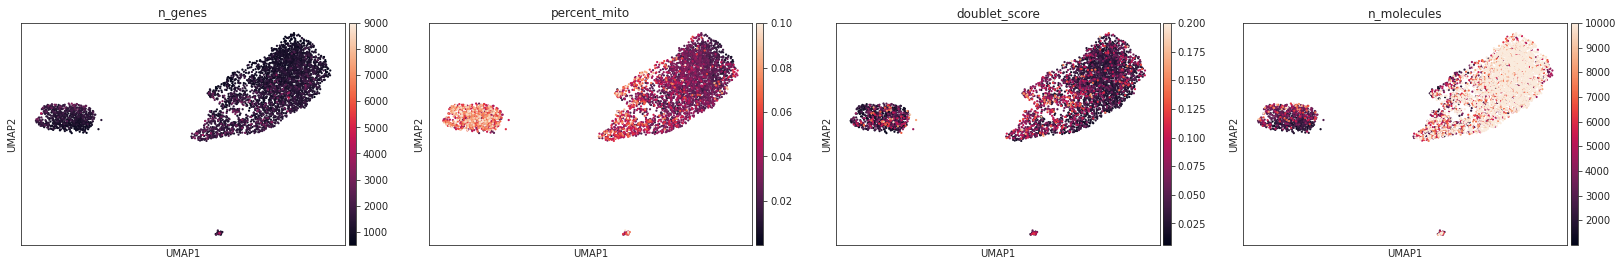

In [18]:
sc.pl.umap(A, color=['n_genes', 'percent_mito', 'doublet_score', 'n_molecules'], legend_loc='on data', size=20, vmax=[9000, 0.1, 0.2, 10000])

# recluster

In [10]:
if 'leiden_backup' not in A.obs.columns:
    A.obs['leiden_backup'] = A.obs.leiden
sc.tl.leiden(A, resolution=0.7)
pipeline.differential_expression_michi_kallisto_recipe(A, groupby='leiden')

Trying to set attribute `.obs` of view, copying.
11/26/2022 09:38:11 PM doing csr->csc
11/26/2022 09:38:11 PM done csr->csc
11/26/2022 09:38:19 PM doing csc->csr
11/26/2022 09:38:19 PM done csc->csr
11/26/2022 09:38:19 PM Filtering DE
11/26/2022 09:38:20 PM Done Filtering DE


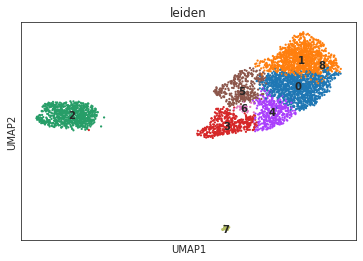

In [11]:
sc.pl.umap(A, color=['leiden'], legend_loc='on data', size=20)

# SCCODA

In [2]:
mkdir /tmp/proportions

mkdir: cannot create directory ‘/tmp/proportions’: File exists


In [3]:
plotfolder = '/tmp/proportions/Bcell_proportions/'
import os 
if not os.path.exists(plotfolder):
    os.mkdir(plotfolder)

In [5]:
A = sc.read_h5ad('/home/mstrasse/TB4/cellTypeProportions/scCODA_ready/Bcell_processed.h5ad')
from crukiopy_release.datatools import fix_diagnosis, diagnosis_fix_dict
A = fix_diagnosis(A)
df_meta = read_metadata()

# again fix diagnosis in those samples
df_meta = df_meta[df_meta.samplename.isin(A.obs.samplename.unique())].set_index('samplename').sort_values('diagnosis')
for s, d in diagnosis_fix_dict.items():
    df_meta.loc[s, 'diagnosis'] = d

In [6]:
data_scanpy_1 = dat.from_scanpy(
    A,
    cell_type_identifier="leiden",
    sample_identifier="samplename",
    covariate_df=df_meta[df_meta.index.isin(A.obs.samplename.unique())]
)
print(data_scanpy_1)

AnnData object with n_obs × n_vars = 46 × 9
    obs: 'foldername', 'patient', 'sequencer', 'tissue', 'flowcell', 'procedure', 'diagnosis', 'treatment', 'phantompurger_folder', 'cruk_sample', 'atlas_sample', 'R2length', 'gender'
    var: 'n_cells'


In [7]:
cluster_order = ['2', '0','1','3','4','5','6','7','8']
diagnosis_ordered = ['NE', 'M','D','T', 'NS']

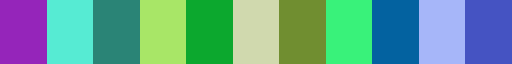

In [9]:
# reorder a little,
from matplotlib.colors import ListedColormap
from crukiopy_release.colormaps import cmap_subtypes
_cm_colors= cmap_subtypes.colors + ['lightgrey']
_cm_colors = np.array(_cm_colors)[[11,
                                   0,1,2,3,4,5,6,7,8,9
                                  ]]
cmap_subtypes = ListedColormap(
    _cm_colors
)
cmap_subtypes

In [10]:
leiden_color_dict = dict(zip(cluster_order, cmap_subtypes.colors ))
_tmp = [leiden_color_dict[c] for c in A.obs.leiden.cat.categories]

if not 'leiden_colors_backup' in A.uns:
    A.uns['leiden_colors_backup']= A.uns['leiden_colors']
A.uns['leiden_colors'] = _tmp

### Saving the adata to disc for later use!!
mkdir /home/mstrasse/TB4/cellTypeProportions/scCODA_ready

In [11]:
# note: need to write the full 35k genes! .to_adata() neatly pulls that out of .raw and applies any other attributes from teh original adata
# B = A.raw.to_adata()
# B.uns = A.uns
# B.obsm = A.obsm
# B.obsp= A.obsp
# B.write_h5ad('/home/mstrasse/TB4/cellTypeProportions/scCODA_ready/Bcell_processed.h5ad')

In [5]:
B = sc.read_h5ad('/home/mstrasse/TB4/cellTypeProportions/scCODA_ready/Bcell_processed.h5ad')

## Proporitions

/home/mstrasse/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


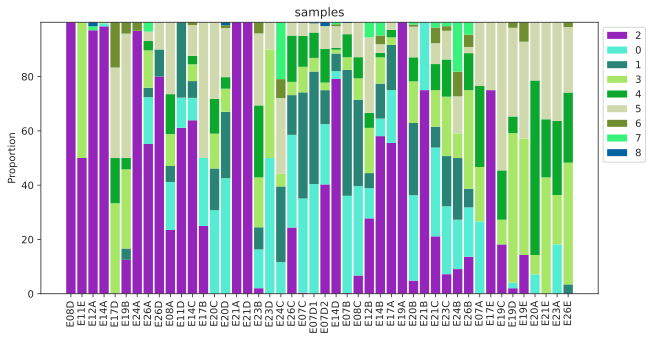

In [12]:
order = []
samplenames = A.obs.samplename.astype(str).unique().tolist()
for d in diagnosis_ordered:
    order.extend(sorted(df_meta.loc[samplenames].query('diagnosis==@d').index))

set_matplotlib_formats('svg')
fig = viz.stacked_barplot(data_scanpy_1[:, cluster_order], feature_name="samples", figsize=(10,5), level_order=order, cmap=cmap_subtypes)
plt.xticks(rotation=90);
fig.figure.savefig(f'{plotfolder}/Bcell_proportions_per_sample.svg')

/home/mstrasse/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
... storing 'diagnosis' as categorical
... storing 'sample_diagnosis' as categorical


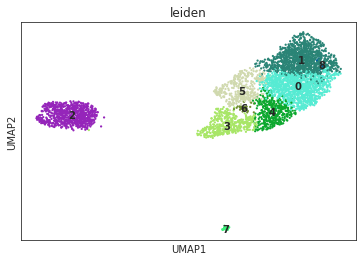

In [16]:
set_matplotlib_formats('png')
sc.pl.umap(A, color=['leiden'], legend_loc='on data', size=20, show=False)
plt.savefig(f'{plotfolder}/Bcell_umap.svg')
plt.savefig(f'{plotfolder}/Bcell_umap.png')

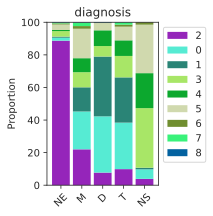

In [24]:
set_matplotlib_formats('svg')
fig = viz.stacked_barplot(data_scanpy_1[:, cluster_order], feature_name="diagnosis", level_order=diagnosis_ordered, cmap=cmap_subtypes, figsize=(2,3))
fig.figure.savefig(f'{plotfolder}/Bcell_proportions_per_diagnosis.svg')
set_matplotlib_formats('png')

In [17]:
q = pd.crosstab(
    pd.Series(pd.Categorical(A.obs.leiden, categories=cluster_order), name='leiden', index=A.obs.leiden.index),
    A.obs.diagnosis
)
norm_freqs = q.div( q.sum(1), axis=0)
norm_freqs = norm_freqs.unstack().reset_index().rename({0:'frequency'}, axis=1)
norm_freqs.diagnosis = pd.Categorical(norm_freqs.diagnosis, categories=diagnosis_ordered)

/home/mstrasse/miniconda3/lib/python3.7/site-packages/plotnine/ggplot.py:721: PlotnineWarning: Saving 3 x 2 in image.
/home/mstrasse/miniconda3/lib/python3.7/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: /tmp/proportions/Bcell_proportions//Bcell_proportions_per_cluster.svg


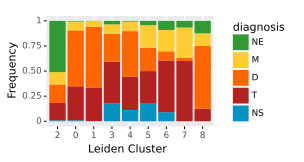

<ggplot: (8753681704689)>

In [27]:
set_matplotlib_formats('svg')
p=pn.ggplot(
    norm_freqs,
    pn.aes(x='leiden', y='frequency', fill='diagnosis')) + pn.geom_bar(stat='identity') \
+ pn.theme(figure_size=(3,2)) + pn.scale_fill_manual(color_dict_diagnosis) + pn.labs(x='Leiden Cluster', y='Frequency')

p.save(f'{plotfolder}/Bcell_proportions_per_cluster.svg')
p

In [28]:
set_matplotlib_formats('png')

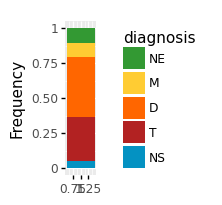

<ggplot: (8753681630421)>

In [29]:
overall_props = A.obs.diagnosis.value_counts()
overall_props = overall_props/overall_props.sum()
overall_props = overall_props.loc[diagnosis_ordered]

_ddd = pd.DataFrame(overall_props).reset_index().rename({'index': 'diagnosis','diagnosis': 'frequency'}, axis=1)
_ddd.diagnosis = pd.Categorical(_ddd.diagnosis, categories=diagnosis_ordered)

pn.ggplot(
    _ddd,
    pn.aes(x=1, y='frequency', fill='diagnosis')) + pn.geom_bar(stat='identity') \
+ pn.theme(figure_size=(7,2)) + pn.scale_fill_manual(color_dict_diagnosis) + pn.theme(figure_size=(0.4,2)) + pn.labs(x='', y='Frequency')

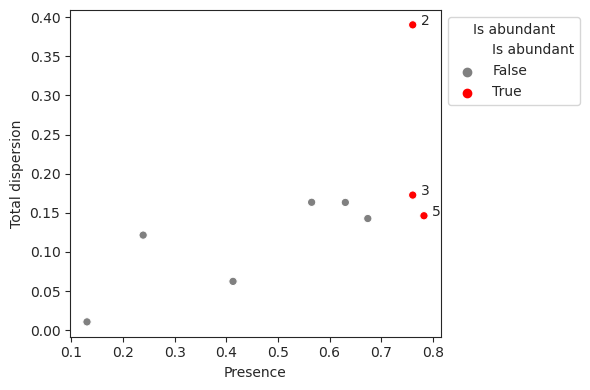

In [43]:
viz.rel_abundance_dispersion_plot(
    data=data_scanpy_1,
    abundant_threshold=0.75
)
plt.show()

In [44]:
model_salm = mod.CompositionalAnalysis(data_scanpy_1, formula="C(diagnosis, Treatment('NE')) + procedure + patient", reference_cell_type="5")
# Run MCMC
sim_results = model_salm.sample_hmc(num_results=3*20000)

Zero counts encountered in data! Added a pseudocount of 0.5.


100%|██████████| 60000/60000 [08:21<00:00, 119.61it/s]


MCMC sampling finished. (546.472 sec)
Acceptance rate: 50.8%


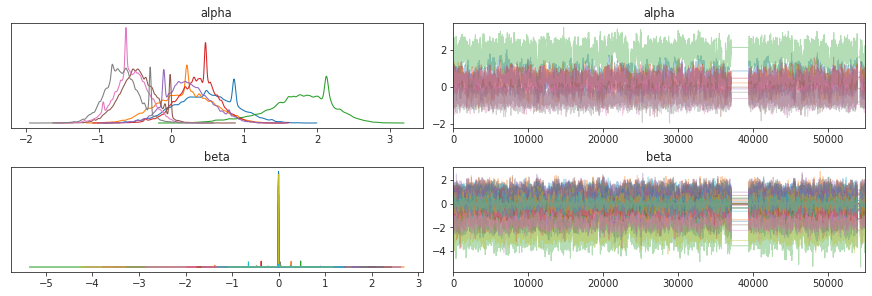

In [45]:
import arviz as az

az.plot_trace(
    sim_results,
    divergences=False,
    var_names=["alpha", "beta"],
    coords={"cell_type": sim_results.posterior.coords["cell_type_nb"]},
)
plt.show()

In [46]:
scCODA_result = sim_results.effect_df
scCODA_result[sim_results.effect_df['Final Parameter'] != 0]

Final Parameter  HDI 3%  \
Covariate                           Cell Type                            
C(diagnosis, Treatment('NE'))[T.D]  2                -2.389499  -3.615   
C(diagnosis, Treatment('NE'))[T.M]  2                -1.410687  -2.272   
C(diagnosis, Treatment('NE'))[T.NS] 2                -2.104675  -3.130   
C(diagnosis, Treatment('NE'))[T.T]  0                 0.891368   0.208   
                                    1                 0.917724   0.209   
                                    2                -1.284997  -2.266   

                                               HDI 97%     SD  \
Covariate                           Cell Type                   
C(diagnosis, Treatment('NE'))[T.D]  2           -1.249  0.660   
C(diagnosis, Treatment('NE'))[T.M]  2           -0.421  0.498   
C(diagnosis, Treatment('NE'))[T.NS] 2           -1.033  0.585   
C(diagnosis, Treatment('NE'))[T.T]  0            1.630  0.436   
                                    1            1.700  0.447   
                                    2           -0.577  0.507   

                                               Inclusion probability  \
Covariate                           Cell Type                          
C(diagnosis, Treatment('NE'))[T.D]  2                       0.999873   
C(diagnosis, Treatment('NE'))[T.M]  2                       0.987873   
C(diagnosis, Treatment('NE'))[T.NS] 2                       0.999564   
C(diagnosis, Treatment('NE'))[T.T]  0                       0.933418   
                                    1                       0.925782   
                                    2                       0.965455   

                                               Expected Sample  \
Covariate                           Cell Type                    
C(diagnosis, Treatment('NE'))[T.D]  2                 5.380137   
C(diagnosis, Treatment('NE'))[T.M]  2                13.081683   
C(diagnosis, Treatment('NE'))[T.NS] 2                 7.021404   
C(diagnosis, Treatment('NE'))[T.T]  0                25.577198   
                                    1                19.610341   
                                    2                10.426351   

                                               log2-fold change  
Covariate                           Cell Type                    
C(diagnosis, Treatment('NE'))[T.D]  2                 -2.802353  
C(diagnosis, Treatment('NE'))[T.M]  2                 -1.520520  
C(diagnosis, Treatment('NE'))[T.NS] 2                 -2.418237  
C(diagnosis, Treatment('NE'))[T.T]  0                  1.291997  
                                    1                  1.330021  
                                    2                 -1.847834

In [47]:
_q = scCODA_result.reset_index()
a = pd.crosstab(_q['Covariate'].replace({
    "C(diagnosis, Treatment('NE'))[T.D]": 'D',
    "C(diagnosis, Treatment('NE'))[T.M]": 'M',
    "C(diagnosis, Treatment('NE'))[T.T]": 'T',
    "C(diagnosis, Treatment('NE'))[T.NS]": 'NS',
    "procedure[T.resection]": 'resection'
    }),
    _q['Cell Type'], 
    values=_q['log2-fold change']* (_q['Final Parameter'] !=0), aggfunc=np.mean).replace({np.nan: 0})

Text(6.0, 0.5, '')

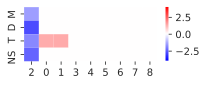

In [50]:
set_matplotlib_formats('svg')

fig, ax = plt.subplots(figsize=(3, 1))
sns.heatmap(a.loc[['M','D','T','NS'], cluster_order], cmap=plt.cm.bwr, vmin=-4, vmax=4)
# plt.title('Log2 fold change (wrt NE)')
plt.xlabel(None)
plt.ylabel(None)

In [ ]:
fig.savefig(f'{plotfolder}/Bcell_scCODA.svg')

In [51]:
set_matplotlib_formats('png')

# cluster two is B cells,
all other cluster plasma cells

/home/mstrasse/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


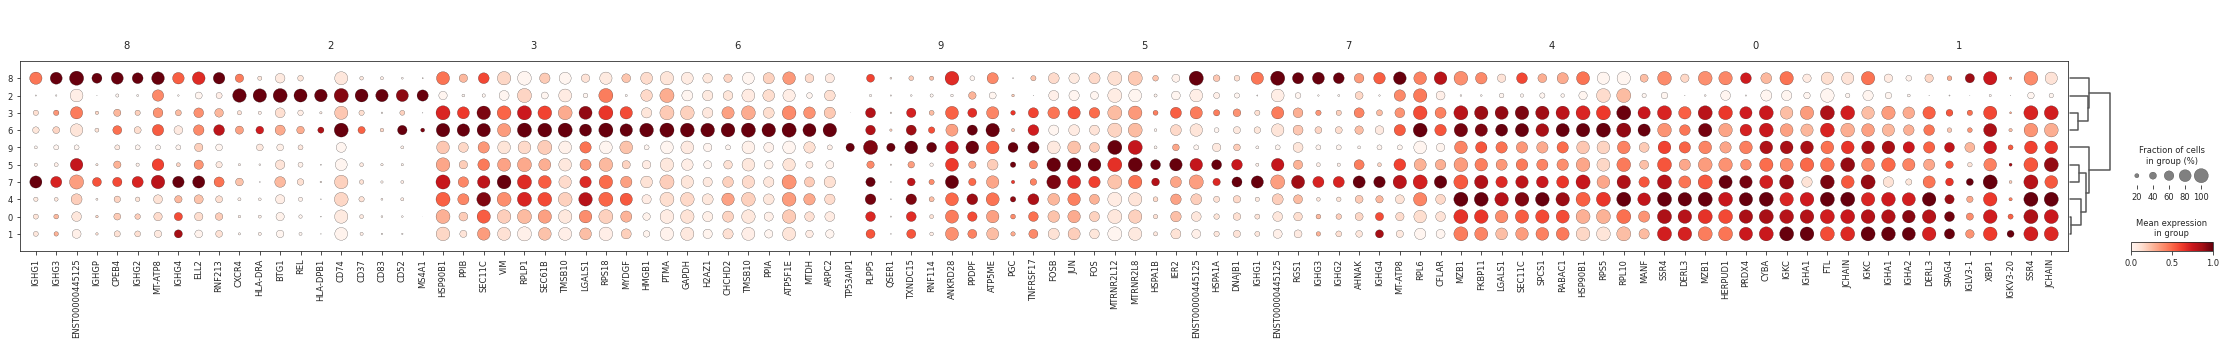

In [38]:
sc.pl.rank_genes_groups_dotplot(A, standard_scale='var')

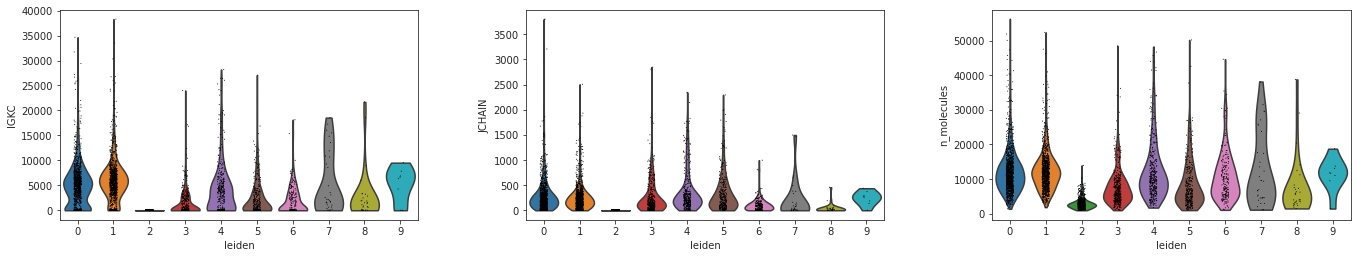

In [45]:
sc.pl.violin(A, keys=['IGKC', 'JCHAIN', 'n_molecules'], groupby='leiden')

In [40]:
sc.tl.tsne(A)
sc.tl.draw_graph(A)

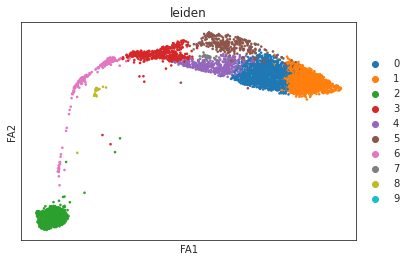

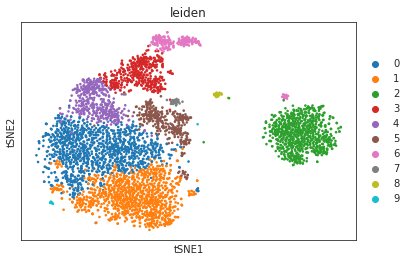

In [43]:
sc.pl.draw_graph(A, color='leiden')
sc.pl.tsne(A, color='leiden')

# Marker plots

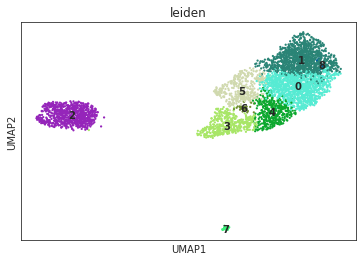

In [18]:
sc.pl.umap(A, color=['leiden'], legend_loc='on data', size=20)

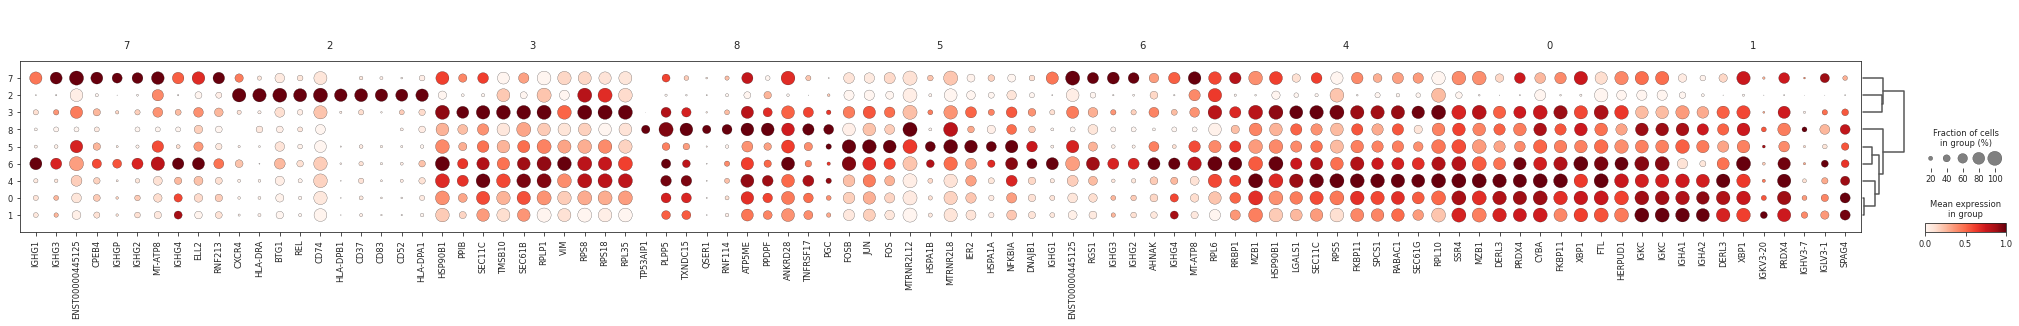

In [19]:
sc.tl.dendrogram(A, groupby='leiden')
sc.pl.rank_genes_groups_dotplot(A, standard_scale='var')

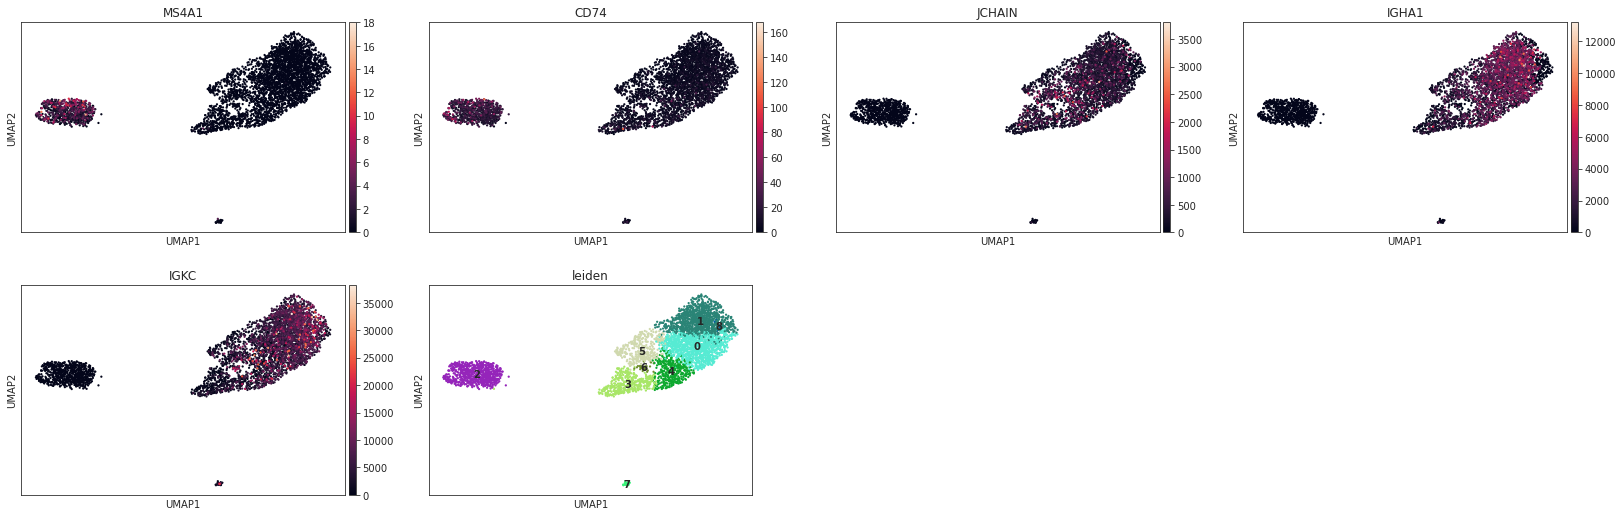

/home/mstrasse/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


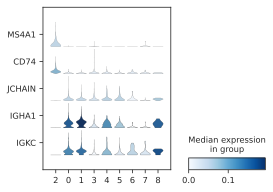

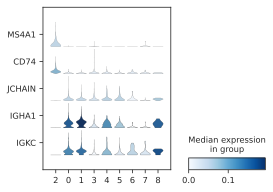

/home/mstrasse/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


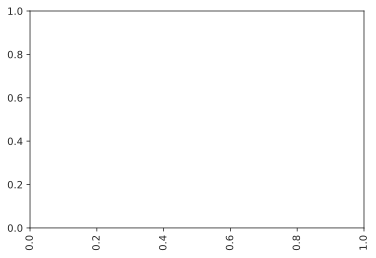

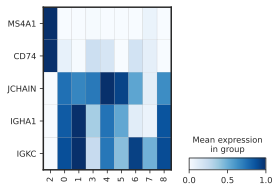

In [26]:
genes =['MS4A1', 'CD74', 'JCHAIN', 'IGHA1','IGKC']
set_matplotlib_formats('png')
sc.pl.umap(A, color=genes+['leiden'], legend_loc='on data', size=20)

B = A.copy()
B.obs['leiden'] = pd.Categorical(B.obs['leiden'], categories=cluster_order)
set_matplotlib_formats('svg')
sc.pl.stacked_violin(B, var_names=genes, groupby='leiden', standard_scale='var', swap_axes=True,show=False,  #order=cluster_order
                figsize=(4,3))
plt.savefig(f'{plotfolder}/Bcell_markers.svg')
sc.pl.stacked_violin(B, var_names=genes, groupby='leiden', standard_scale='var', swap_axes=True, use_raw=False,  #order=cluster_order
                figsize=(4,3))
plt.xticks(rotation=90);

sc.pl.matrixplot(B, var_names=genes, groupby='leiden', standard_scale='var', swap_axes=True, show=False, #order=cluster_order
                figsize=(4,3), cmap='Blues')
plt.savefig(f'{plotfolder}/Bcell_markers_matrix.svg')